In [20]:
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Rutas al dataset y archivos
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/imagenes_m2'
csv_path = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/filtered_with_image_names.csv'
output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test'

# Crear carpetas principales (training y test)
train_folder = os.path.join(output_root, 'training')
test_folder = os.path.join(output_root, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Crear carpetas de masas y calcificaciones, y sus subcarpetas (benigno, maligno, sospechoso) dentro de 'training' y 'test'
for split_folder in [train_folder, test_folder]:
    os.makedirs(os.path.join(split_folder, 'masas', 'benigno'), exist_ok=True)
    os.makedirs(os.path.join(split_folder, 'masas', 'maligno'), exist_ok=True)
    os.makedirs(os.path.join(split_folder, 'masas', 'sospechoso'), exist_ok=True)
    os.makedirs(os.path.join(split_folder, 'calcificaciones', 'benigno'), exist_ok=True)
    os.makedirs(os.path.join(split_folder, 'calcificaciones', 'maligno'), exist_ok=True)
    os.makedirs(os.path.join(split_folder, 'calcificaciones', 'sospechoso'), exist_ok=True)

# Tamaño objetivo al que queremos llegar para el recorte (similar a 299x299)
TARGET_SIZE = (299, 299)
MIN_SIZE = 598  # El tamaño objetivo para la imagen sin padding.

# Leer las anotaciones CSV que contienen las coordenadas de la ROI
ss1 = pd.read_csv(csv_path)

# Limpiar las categorías eliminando los caracteres adicionales
ss1['finding_categories'] = ss1['finding_categories'].apply(lambda x: x.strip("[]'"))

# Crear un DataFrame vacío para guardar las nuevas coordenadas
ss1_rescaled = pd.DataFrame(columns=ss1.columns)

# Función para obtener la ruta del archivo DICOM usando image_id
def get_dicom_path(image_id):
    for study_id in os.listdir(dicom_root):
        study_path = os.path.join(dicom_root, study_id)
        if os.path.isdir(study_path):
            dicom_path = os.path.join(study_path, image_id + '.dicom')
            if os.path.exists(dicom_path):
                return dicom_path
    raise FileNotFoundError(f"No se encontró el archivo DICOM para image_id: {image_id}")

# Función para aplicar el recorte basado en el centro de la ROI, con padding variable.
def extract_roi(image_name, split, birads, finding_categories, ss1_rescaled):
    # Obtener el image_id (parte antes del guión bajo "_")
    image_id = image_name.split('_')[0]
    dicom_path = get_dicom_path(image_id)

    # Leer la imagen DICOM
    dicom = pydicom.dcmread(dicom_path)
    img = dicom.pixel_array

    # Aplicar VOI LUT para ajustar la imagen según los metadatos del DICOM
    img_windowed = apply_voi_lut(img, dicom)

    # Normalizar la imagen para que esté en el rango [0, 255]
    img_windowed = (img_windowed - img_windowed.min()) / (img_windowed.max() - img_windowed.min()) * 255
    img_windowed = img_windowed.astype(np.uint8)

    # Extraer las coordenadas de la ROI desde el CSV utilizando el image_name
    try:
        x1, y1 = (int(ss1.loc[ss1['image_name'] == image_name, 'xmin'].values[0]),
                  int(ss1.loc[ss1['image_name'] == image_name, 'ymin'].values[0]))
        x2, y2 = (int(ss1.loc[ss1['image_name'] == image_name, 'xmax'].values[0]),
                  int(ss1.loc[ss1['image_name'] == image_name, 'ymax'].values[0]))
    except IndexError:
        print(f"Error: No se encontraron coordenadas para la ROI de la imagen {image_name}.")
        return ss1_rescaled

    # Verificar que las coordenadas sean válidas
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_windowed.shape[1], x2)
    y2 = min(img_windowed.shape[0], y2)
    
    # Calcular el centro de la ROI
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Determinar el tamaño de la ROI original
    width = x2 - x1
    height = y2 - y1

    # Agregar padding variable según el tamaño de la ROI
    if width < MIN_SIZE or height < MIN_SIZE:
        # ROI es más pequeña que el tamaño objetivo, añadimos padding (20%)
        padding_x = int(width * 0.2)
        padding_y = int(height * 0.2)
    else:
        # ROI es mayor, añadimos menos padding (5%)
        padding_x = int(width * 0.05)
        padding_y = int(height * 0.05)

    # Establecer los nuevos límites de la imagen recortada, con padding
    x1_new = max(center_x - (MIN_SIZE // 2) - padding_x, 0)
    y1_new = max(center_y - (MIN_SIZE // 2) - padding_y, 0)
    x2_new = min(center_x + (MIN_SIZE // 2) + padding_x, img_windowed.shape[1])
    y2_new = min(center_y + (MIN_SIZE // 2) + padding_y, img_windowed.shape[0])

    # Recortar la imagen utilizando las nuevas coordenadas ajustadas
    crop = img_windowed[y1_new:y2_new, x1_new:x2_new]

    # Verificar si el recorte no está vacío
    if crop.size == 0:
        print(f"Error: El recorte para la imagen {image_name} está vacío.")
        return ss1_rescaled

    # Redimensionar el recorte a 299x299 píxeles
    try:
        crop_resized = cv2.resize(crop, TARGET_SIZE)
    except cv2.error as e:
        print(f"Error al redimensionar el recorte para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Calcular las nuevas coordenadas reescaladas
    scale_x = TARGET_SIZE[0] / crop.shape[1]
    scale_y = TARGET_SIZE[1] / crop.shape[0]

    xmin_rescaled = int((x1 - x1_new) * scale_x)
    ymin_rescaled = int((y1 - y1_new) * scale_y)
    xmax_rescaled = int((x2 - x1_new) * scale_x)
    ymax_rescaled = int((y2 - y1_new) * scale_y)

    # Ajuste en el split: manejar 'train', 'training' y 'test'
    if split in ['train', 'training']:
        base_dir = train_folder
    elif split == 'test':
        base_dir = test_folder
    else:
        print(f"Error: Split desconocido '{split}' para la imagen {image_name}.")
        return ss1_rescaled

    # Verificar si se asigna una categoría válida a la variable output_dir
    if finding_categories == 'Mass':
        output_dir = os.path.join(base_dir, 'masas')
    elif finding_categories == 'Suspicious Calcification':
        output_dir = os.path.join(base_dir, 'calcificaciones')
    else:
        print(f"Error: Categoría desconocida '{finding_categories}' para la imagen {image_name}.")
        return ss1_rescaled

    # Categorizar en benigno, maligno, o sospechoso según el valor de BIRADS
    if birads == 'BI-RADS 3':
        output_dir = os.path.join(output_dir, 'benigno')
    elif birads == 'BI-RADS 5':
        output_dir = os.path.join(output_dir, 'maligno')
    elif birads == 'BI-RADS 4':
        output_dir = os.path.join(output_dir, 'sospechoso')
    else:
        print(f"Error: BIRADS desconocido '{birads}' para la imagen {image_name}.")
        return ss1_rescaled

    # Guardar la imagen recortada con el formato {image_name}.png
    roi_filename = f"{image_name}.png"
    output_path = os.path.join(output_dir, roi_filename)
    cv2.imwrite(output_path, crop_resized)
    print(f"Imagen ROI guardada en: {output_path}")

    # Guardar las coordenadas reescaladas en el nuevo CSV
    new_row = ss1.loc[ss1['image_name'] == image_name].copy()
    new_row['xmin'] = xmin_rescaled
    new_row['ymin'] = ymin_rescaled
    new_row['xmax'] = xmax_rescaled
    new_row['ymax'] = ymax_rescaled
    ss1_rescaled = pd.concat([ss1_rescaled, new_row], ignore_index=True)

    return ss1_rescaled

# Función para recorrer todas las imágenes del CSV y guardar las ROI redimensionadas y las nuevas coordenadas
def process_all_images():
    global ss1_rescaled
    for _, row in ss1.iterrows():
        image_name = row['image_name']
        split = row['split']  # La columna 'split' tiene los valores 'train', 'training', o 'test'
        birads = row['finding_birads']  # Columna con los valores BIRADS
        finding_categories = row['finding_categories']  # Columna con el tipo de hallazgo (mass o suspicious)

        # Procesar cada imagen y almacenar las ROI y coordenadas reescaladas
        ss1_rescaled = extract_roi(image_name, split, birads, finding_categories, ss1_rescaled)

    # Guardar el nuevo CSV con las coordenadas reescaladas
    ss1_rescaled.to_csv(new_csv_path, index=False)
    print(f"Nuevo CSV guardado en: {new_csv_path}")

# Ejecutar el procesamiento de todas las imágenes
process_all_images()



Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/masas/sospechoso/001ade2a3cb53fd808bd2856a0df5413_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/calcificaciones/sospechoso/001ade2a3cb53fd808bd2856a0df5413_1.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/calcificaciones/sospechoso/001ade2a3cb53fd808bd2856a0df5413_2.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/calcificaciones/sospechoso/002074412a8fc178c271fb93b55c3e29_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/masas/benigno/002460132586dc0c7b88a59dce6e77bd_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/proc

/var/folders/ds/4z7lc9ld4mqb377_3t2v4lxm0000gn/T/ipykernel_25078/4170785012.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ss1_rescaled = pd.concat([ss1_rescaled, new_row], ignore_index=True)


Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/test/masas/sospechoso/01958718afdf303581e758cdf34eaf8a_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/masas/maligno/01df962b078e38500bf9dd9969a50083_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/masas/benigno/01fb871dc222684a9950609b62b76772_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/masas/benigno/02895cbbcb504f54c6882c4c5695f563_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/test/calcificaciones/sospechoso/02b3206d267eb7f354113b0c5365127b_0.png
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test/training/m

['BI-RADS 4' 'BI-RADS 3' 'BI-RADS 5']


Carpeta: training/masas/benigno - 443 imágenes


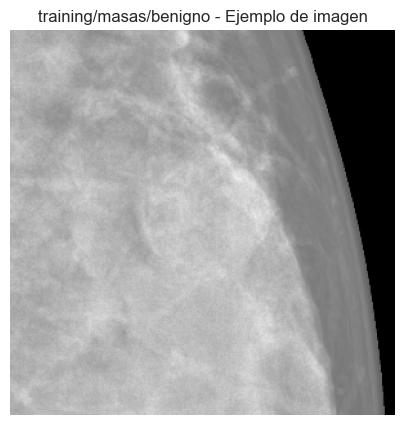

Carpeta: training/masas/maligno - 90 imágenes


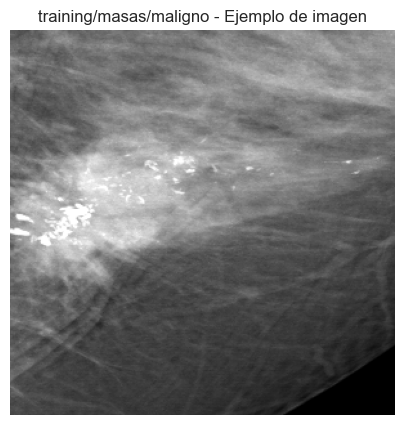

Carpeta: training/masas/sospechoso - 372 imágenes


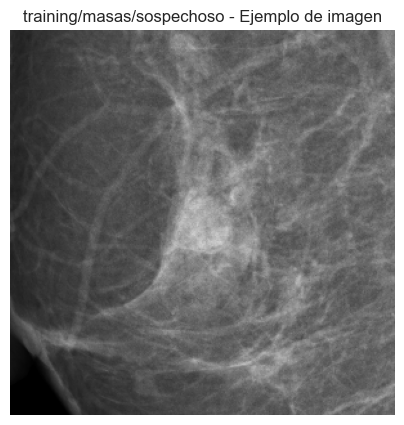

Carpeta: training/calcificaciones/benigno - 54 imágenes


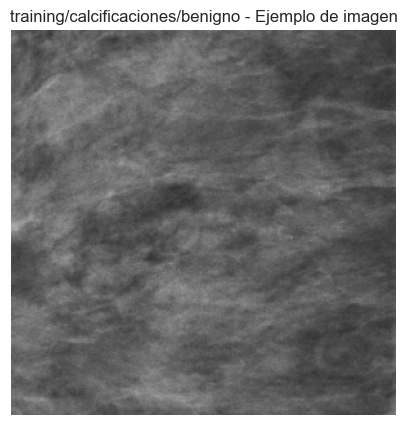

Carpeta: training/calcificaciones/maligno - 33 imágenes


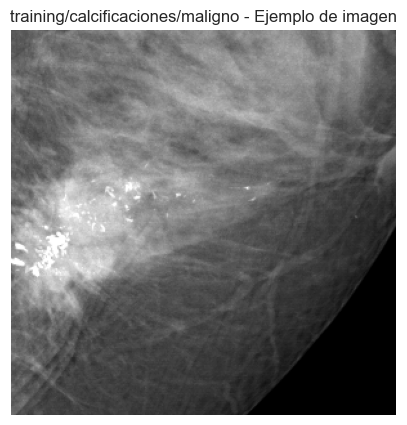

Carpeta: training/calcificaciones/sospechoso - 224 imágenes


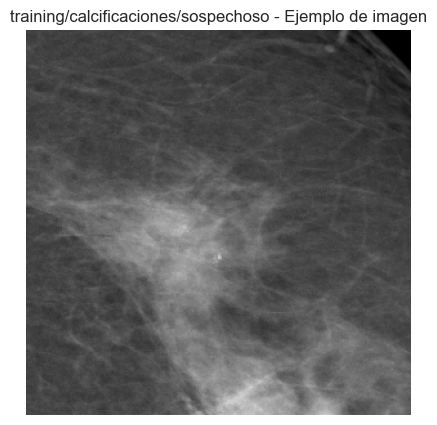

Carpeta: test/masas/benigno - 123 imágenes


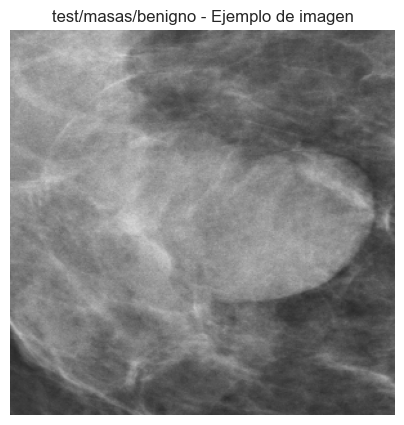

Carpeta: test/masas/maligno - 14 imágenes


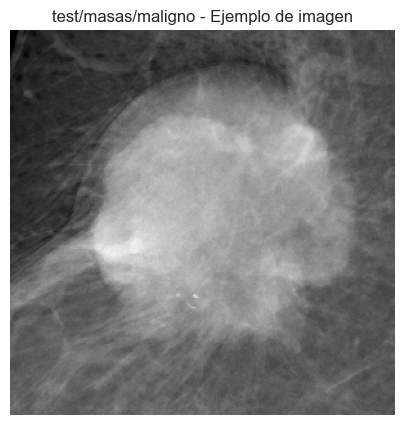

Carpeta: test/masas/sospechoso - 81 imágenes


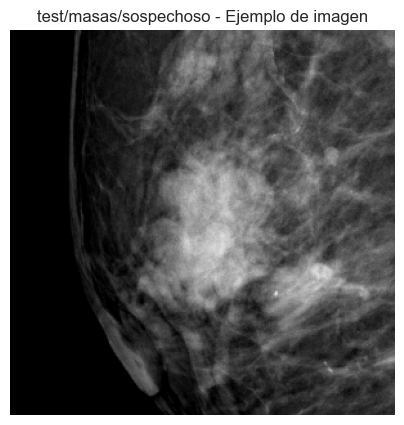

Carpeta: test/calcificaciones/benigno - 11 imágenes


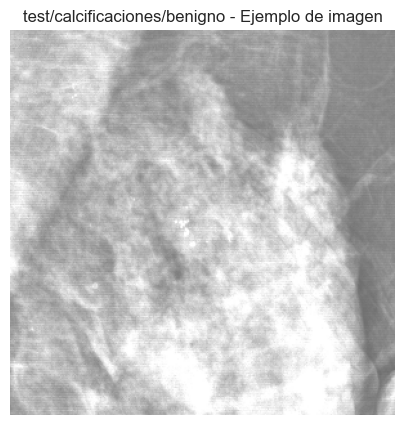

Carpeta: test/calcificaciones/maligno - 20 imágenes


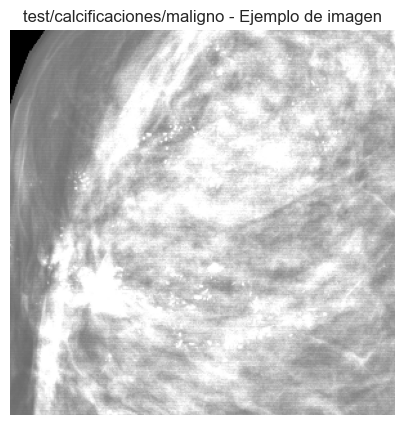

Carpeta: test/calcificaciones/sospechoso - 60 imágenes


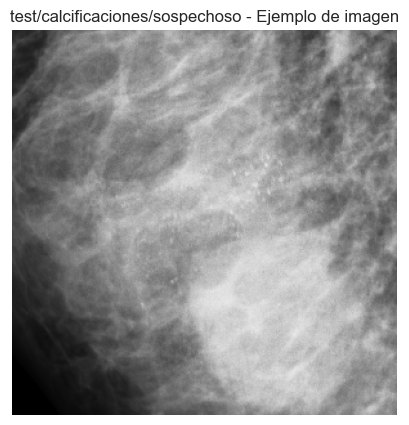

In [1]:
import os
import matplotlib.pyplot as plt
import cv2

# Ruta principal donde están las carpetas de 'training' y 'test'
output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test'

# Función para contar imágenes en las subcarpetas y plotear una de cada una
def count_images_and_plot_example():
    for split in ['training', 'test']:
        split_path = os.path.join(output_root, split)
        if not os.path.exists(split_path):
            print(f"No se encontró la carpeta: {split_path}")
            continue
        
        for category in ['masas', 'calcificaciones']:
            category_path = os.path.join(split_path, category)
            
            for diagnosis in ['benigno', 'maligno', 'sospechoso']:
                diagnosis_path = os.path.join(category_path, diagnosis)
                
                if os.path.exists(diagnosis_path):
                    # Listar las imágenes en la carpeta
                    images = [f for f in os.listdir(diagnosis_path) if f.endswith('.png')]
                    num_images = len(images)
                    
                    # Imprimir el conteo de imágenes
                    print(f"Carpeta: {split}/{category}/{diagnosis} - {num_images} imágenes")
                    
                    if num_images > 0:
                        # Mostrar una imagen como ejemplo
                        image_path = os.path.join(diagnosis_path, images[0])
                        img = cv2.imread(image_path)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB para mostrar correctamente en matplotlib
                        
                        plt.figure(figsize=(5, 5))
                        plt.imshow(img)
                        plt.title(f"{split}/{category}/{diagnosis} - Ejemplo de imagen")
                        plt.axis('off')
                        plt.show()
                else:
                    print(f"No se encontró la carpeta: {diagnosis_path}")

# Ejecutar la función
count_images_and_plot_example()


In [22]:
### Contamos cuantos recortes hay en cada carpeta

In [23]:
import os

# Rutas principales para 'training' y 'test'
output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/ROI_Training_Test'

# Subcarpetas a recorrer (benigno, maligno, sospechoso)
categorias = ['benigno', 'maligno', 'sospechoso']

# Función para contar cuántos archivos hay en una subcarpeta
def contar_archivos_en_categoria(ruta_base, categoria):
    categoria_path = os.path.join(ruta_base, categoria)
    try:
        # Listar archivos en la carpeta
        archivos = os.listdir(categoria_path)
        # Filtrar solo los archivos que sean imágenes (.png)
        archivos_imagenes = [archivo for archivo in archivos if archivo.endswith('.png')]
        return len(archivos_imagenes)
    except FileNotFoundError:
        print(f"No se encontró la carpeta: {categoria_path}")
        return 0

# Función para contar archivos en las carpetas de 'training' o 'test'
def contar_archivos_en_split(split_name):
    print(f"\nConteo de recortes en la carpeta '{split_name}':")
    
    # Rutas a las carpetas de masas y calcificaciones dentro de cada split ('training' o 'test')
    output_masas = os.path.join(output_root, split_name, 'masas')
    output_calcificaciones = os.path.join(output_root, split_name, 'calcificaciones')
    
    # Inicializar los contadores
    total_masas = 0
    total_calcificaciones = 0

    # Contar archivos en cada categoría de masas
    print("\nMasas:")
    for categoria in categorias:
        num_recortes = contar_archivos_en_categoria(output_masas, categoria)
        print(f"{categoria}: {num_recortes} recortes")
        total_masas += num_recortes

    # Contar archivos en cada categoría de calcificaciones
    print("\nCalcificaciones:")
    for categoria in categorias:
        num_recortes = contar_archivos_en_categoria(output_calcificaciones, categoria)
        print(f"{categoria}: {num_recortes} recortes")
        total_calcificaciones += num_recortes

    # Calcular el total de recortes
    total_recortes = total_masas + total_calcificaciones

    print(f"\nTotal de recortes en 'masas': {total_masas}")
    print(f"Total de recortes en 'calcificaciones': {total_calcificaciones}")
    print(f"Total general de recortes en '{split_name}': {total_recortes}")

# Contar archivos en las carpetas 'training' y 'test'
contar_archivos_en_split('training')
contar_archivos_en_split('test')



Conteo de recortes en la carpeta 'training':

Masas:
benigno: 443 recortes
maligno: 90 recortes
sospechoso: 372 recortes

Calcificaciones:
benigno: 54 recortes
maligno: 33 recortes
sospechoso: 224 recortes

Total de recortes en 'masas': 905
Total de recortes en 'calcificaciones': 311
Total general de recortes en 'training': 1216

Conteo de recortes en la carpeta 'test':

Masas:
benigno: 123 recortes
maligno: 14 recortes
sospechoso: 81 recortes

Calcificaciones:
benigno: 11 recortes
maligno: 20 recortes
sospechoso: 60 recortes

Total de recortes en 'masas': 218
Total de recortes en 'calcificaciones': 91
Total general de recortes en 'test': 309
